In [1]:
#Importing libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles statistical models.
import os

In [2]:
#Configure API keys
quandl.ApiConfig.api_key = 'qFeidsL1wUcJ9NLa5_bU'


In [3]:
# Importing the Federal Reserve Economic Data \"Natural Rate of Unemployment\" variable
data = quandl.get('FRED/NROU')

In [4]:
data.head(5)

,Value
Date,
1949-01-01,5.255053
1949-04-01,5.261516
1949-07-01,5.268013
1949-10-01,5.274564
1950-01-01,5.281182


In [5]:
data.shape

(332, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

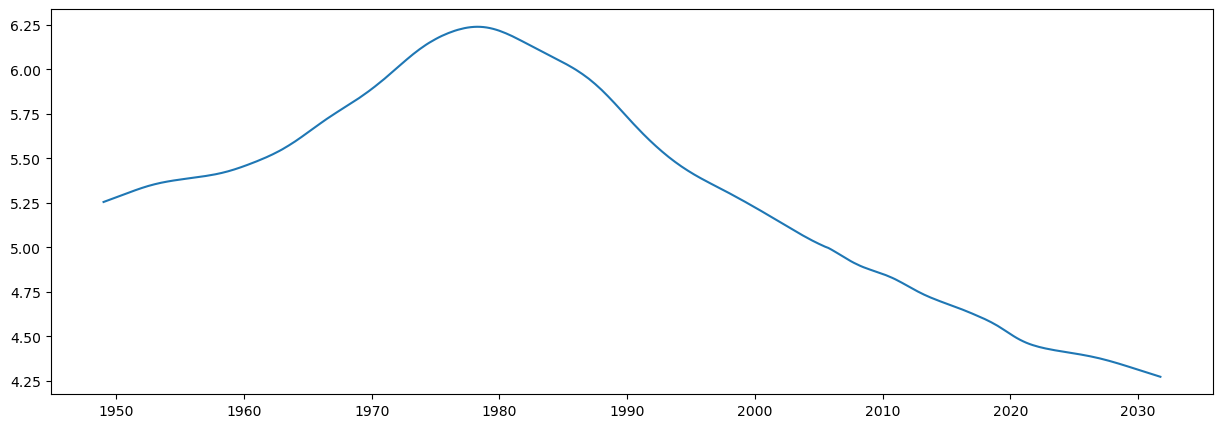

In [7]:
# Plot the data using matplotlib
plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,  it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!
plt.plot(data)

In [8]:
# Subsetting, wrangling, and cleaning time-series data
# Reset index so that you can use the \"Date\" column as a filter
data_2 = data.reset_index()

In [9]:
data_2.head()

,Date,Value
0,1949-01-01,5.255053
1,1949-04-01,5.261516
2,1949-07-01,5.268013
3,1949-10-01,5.274564
4,1950-01-01,5.281182


In [10]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-06-01')]

In [11]:
data_sub.shape

(162, 2)

In [12]:
data_sub.head()

,Date,Value
124,1980-01-01,6.217371
125,1980-04-01,6.210709
126,1980-07-01,6.203388
127,1980-10-01,6.195496
128,1981-01-01,6.187123


In [13]:
# Set the \"Date\" column as the index
from datetime import datetime

In [14]:
data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from \"Date.

C:\Users\B.Archibong\AppData\Local\Temp\ipykernel_8240\2579910076.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from \"Date.


In [15]:
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.

In [16]:
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the \"Date\" column

In [17]:
data_sub.head()

,Value
datetime,
1980-01-01,6.217371
1980-04-01,6.210709
1980-07-01,6.203388
1980-10-01,6.195496
1981-01-01,6.187123


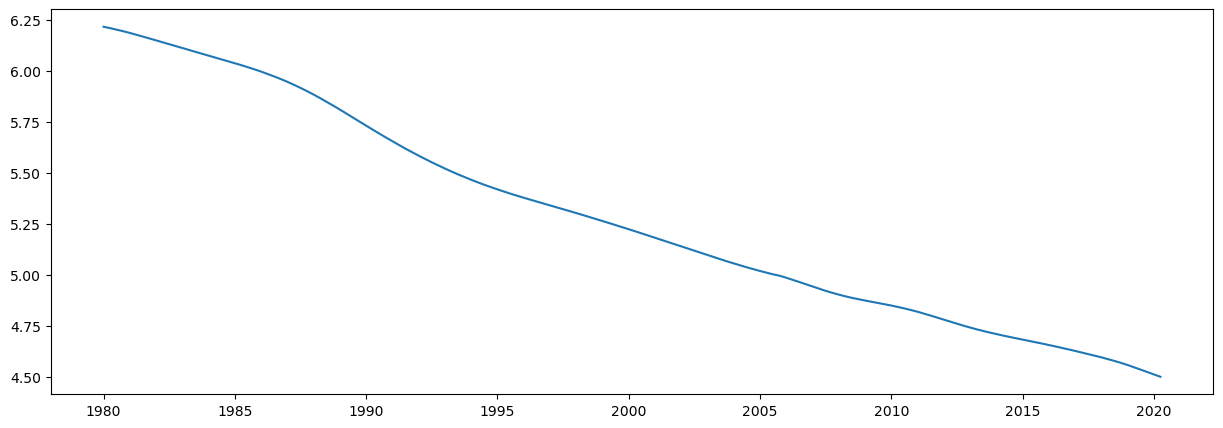

In [18]:
# Plot the new data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [19]:
# Check for missing values #no missing values
data_sub.isnull().sum()

Value    0
dtype: int64

In [20]:
# Check for duplicates # no dups
dups = data_sub.duplicated()
dups.sum()

0

In [21]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [22]:
from pylab import rcParams 

In [23]:
rcParams['figure.figsize'] = 18, 7

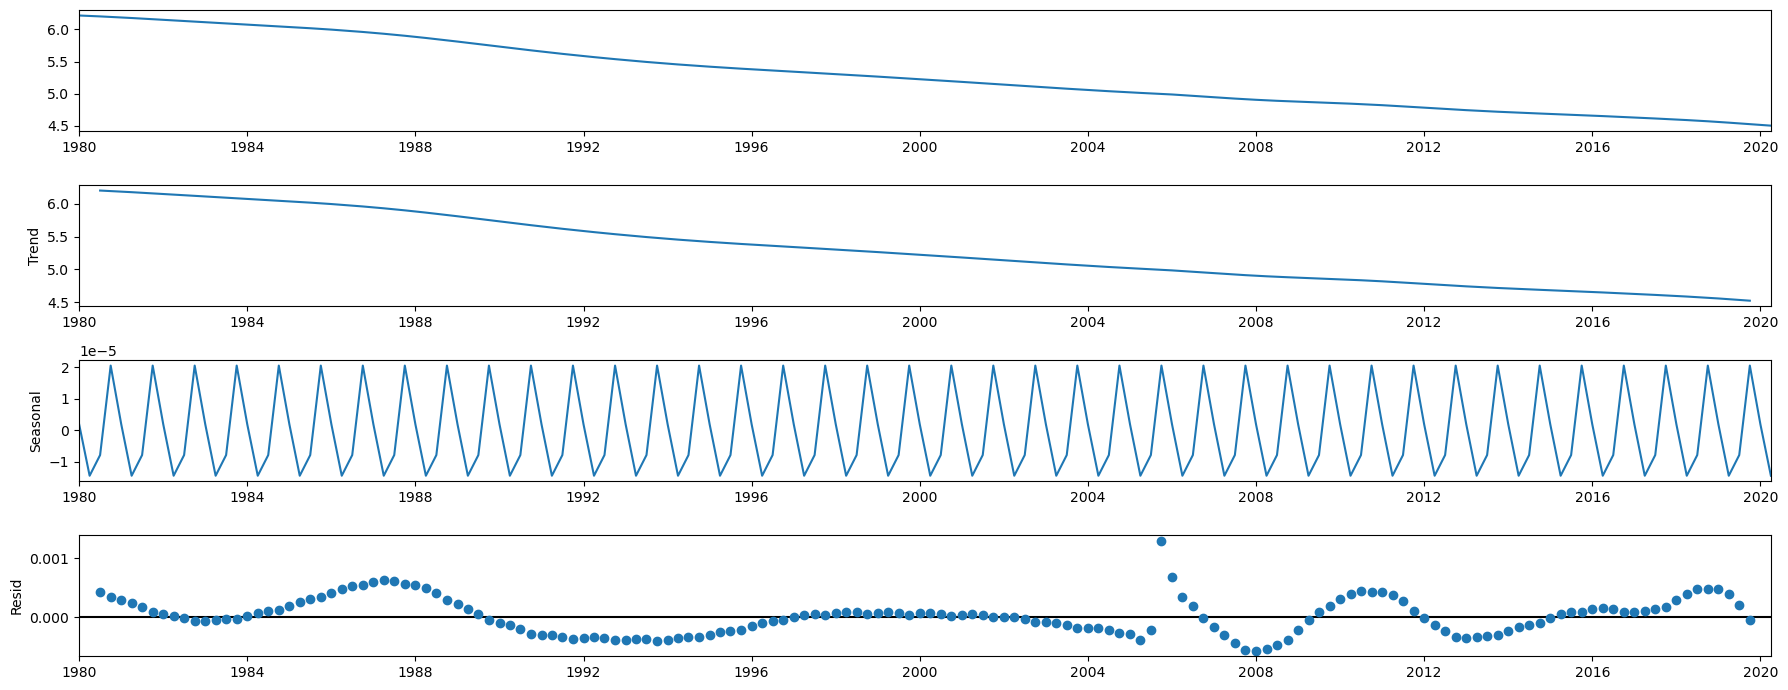

In [24]:
# Plot the separate components
decomposition.plot()
plt.show()

In [26]:
#comments
#The trend in the chart above gradually drops in a linear fashion after 1980. While there’s one jump around 2009, likely due to the global financial crisis, the overall trend continues to decrease all the way until the present year. This is called a dominant trend.

#The third component is the seasonality. Seasonal fluctuations represented by a spikey curve that changes at a regular interval is seen here.

#The final component is the noise—or, as it’s called here, “residual.” It is what’s left of the data after the trend and seasonality have been extracted (hence the term residual).


In [30]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

In [39]:
def dickey_fuller(timeseries): # Define the function
  #Perform the Dickey-Fuller test
  print ('Dickey-Fuller Stationarity test:')
  test = adfuller(timeseries, autolag='AIC')
  result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
  for key,value in test[4].items():
   result['Critical Value (%s)'%key] = value
  print (result)

In [41]:
#Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.745331
p-value                          0.407921
Number of Lags Used              4.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


In [ ]:
#Comments
#Using a significance level of 5 percent. I’d need to look at the “Critical Value (5%)” in the results, which above has a value of -2.880878. This is much smaller than the test statistic, which is -1.738876, which means that I can’t reject the null hypothesis.

#This means there is a unit root in the data, and the data is non-stationary.

#I could have been able to reject the null hypothesis if the critical value was larger than the test statistic.

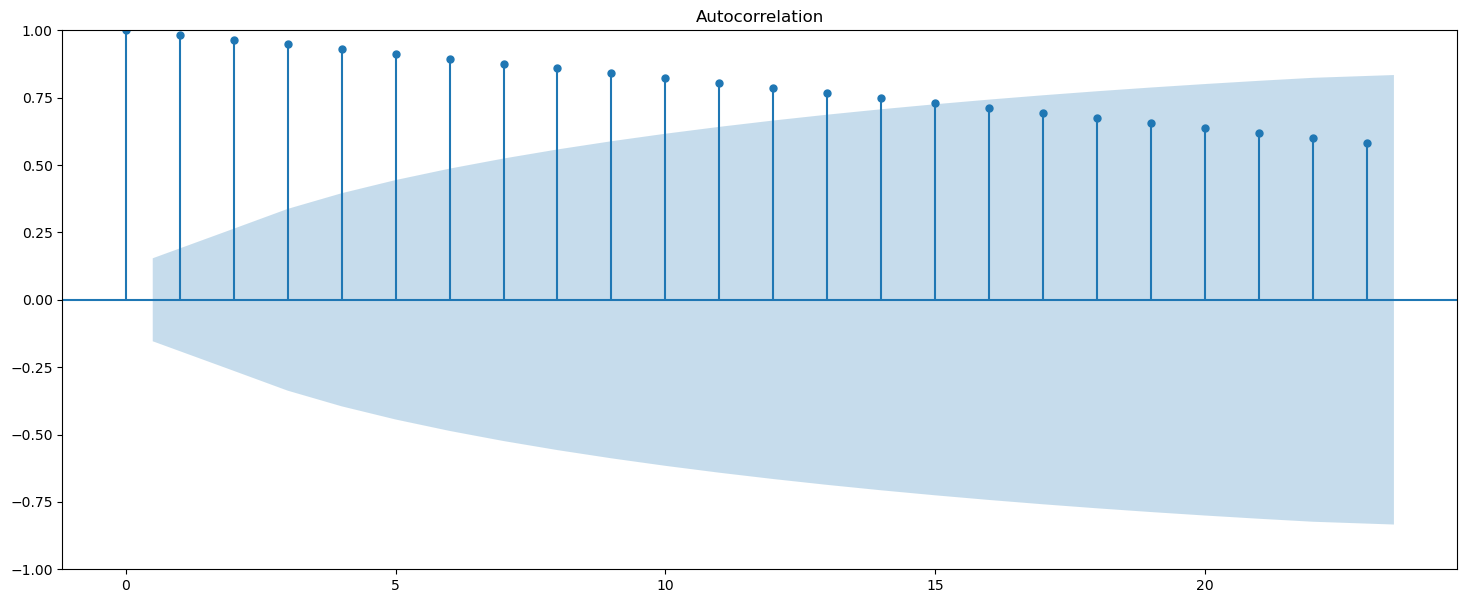

In [42]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots\n",
plot_acf(data_sub)
plt.show()

In [43]:
#Comments
#The blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means that there are lags that are significantly correlated with each other.
#And when there are many lags beyond this interval as can be seen in the plot above, It can be deduced that the data is non-stationary
#This means there’s a lot of autocorrelated data and the set is likely non-stationary, which supports the result of the Dickey-Fuller test you conducted earlier.
#This has proven that the data is non-stationary (has a trend), and since I can’t forecast with non-stationary data, I first need to make it stationary.

In [44]:
#Stationarizing the Federal Reserve Economic Data #Differencing
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
   

In [45]:
data_diff.dropna(inplace = True) # Here,missing values that came about as a result of the differencing are removed.
# If not removed,it will not be possible to run the Dickey-Fuller test

In [46]:
data_diff.head()

,Value
datetime,
1980-04-01,-0.006662
1980-07-01,-0.007321
1980-10-01,-0.007892
1981-01-01,-0.008373
1981-04-01,-0.008762


In [47]:
data_diff.columns

Index(['Value'], dtype='object')

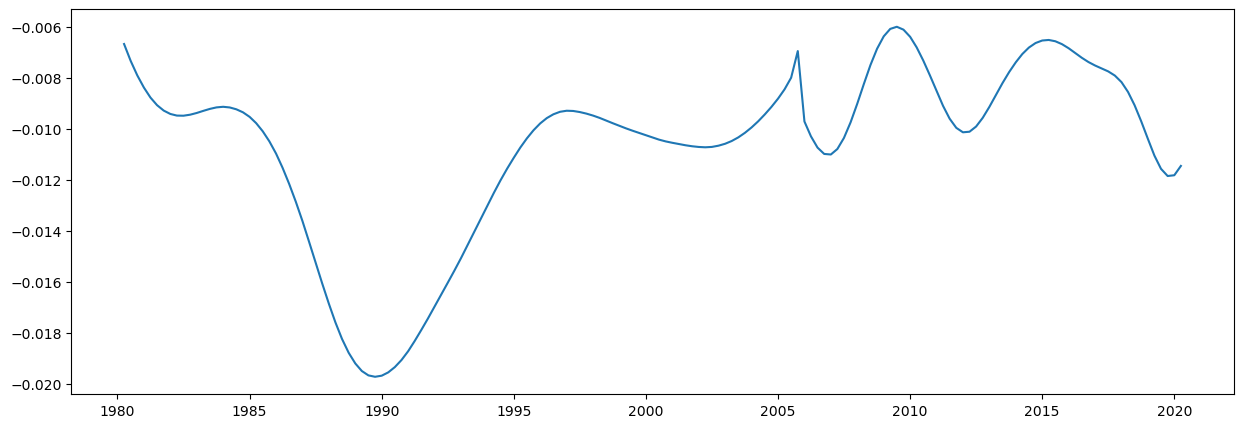

In [48]:
# Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [49]:
#Conducting the dickey_fuller again after removing trend
dickey_fuller(data_diff['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.451840
p-value                          0.127636
Number of Lags Used              2.000000
Number of Observations Used    158.000000
Critical Value (1%)             -3.472431
Critical Value (5%)             -2.880013
Critical Value (10%)            -2.576619
dtype: float64


In [50]:
#Comments
#Using a significance level of 5 percent. I’d need to look at the “Critical Value (5%)” in the results, which above has a value of -2.880013. This is smaller than the test statistic, which is -2.451840, which means that I can’t reject the null hypothesis.

#This means there is a unit root in the data, and the data is non-stationary.

#I could have been able to reject the null hypothesis if the critical value was larger than the test statistic.

In [65]:
#Conducting another round of differencing
data_diff2 = data_sub - data_sub.shift(2) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
   

In [66]:
data_diff2.dropna(inplace = True) # Here,missing values that came about as a result of the differencing are removed.
# If not removed,it will not be possible to run the Dickey-Fuller test

In [67]:
data_diff2.head()

,Value
datetime,
1980-07-01,-0.013983
1980-10-01,-0.015213
1981-01-01,-0.016265
1981-04-01,-0.017134
1981-07-01,-0.017821


In [68]:
data_diff2.columns

Index(['Value'], dtype='object')

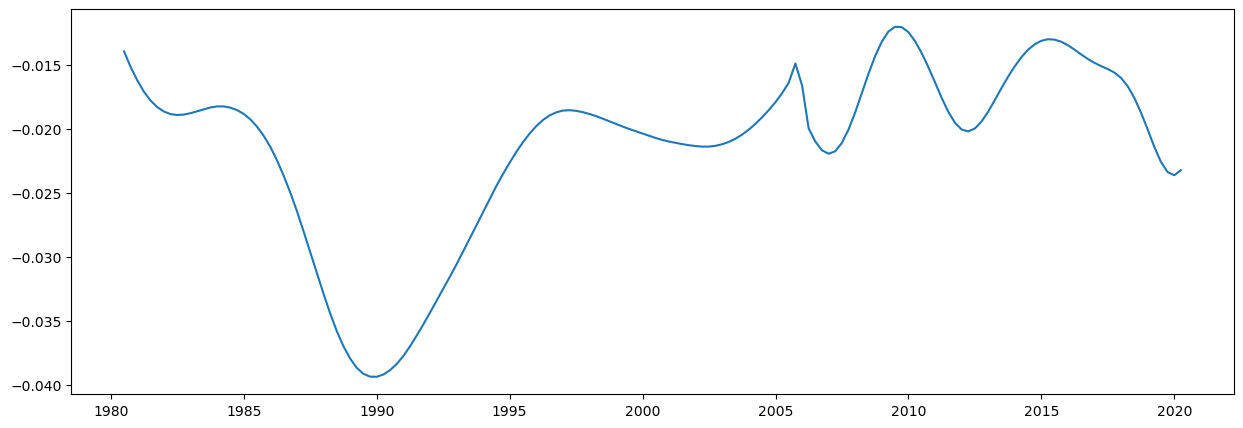

In [69]:
# Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff2)

In [70]:
#Conducting the dickey_fuller again after another differencing
dickey_fuller(data_diff2['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.015502
p-value                          0.279818
Number of Lags Used              9.000000
Number of Observations Used    150.000000
Critical Value (1%)             -3.474715
Critical Value (5%)             -2.881009
Critical Value (10%)            -2.577151
dtype: float64


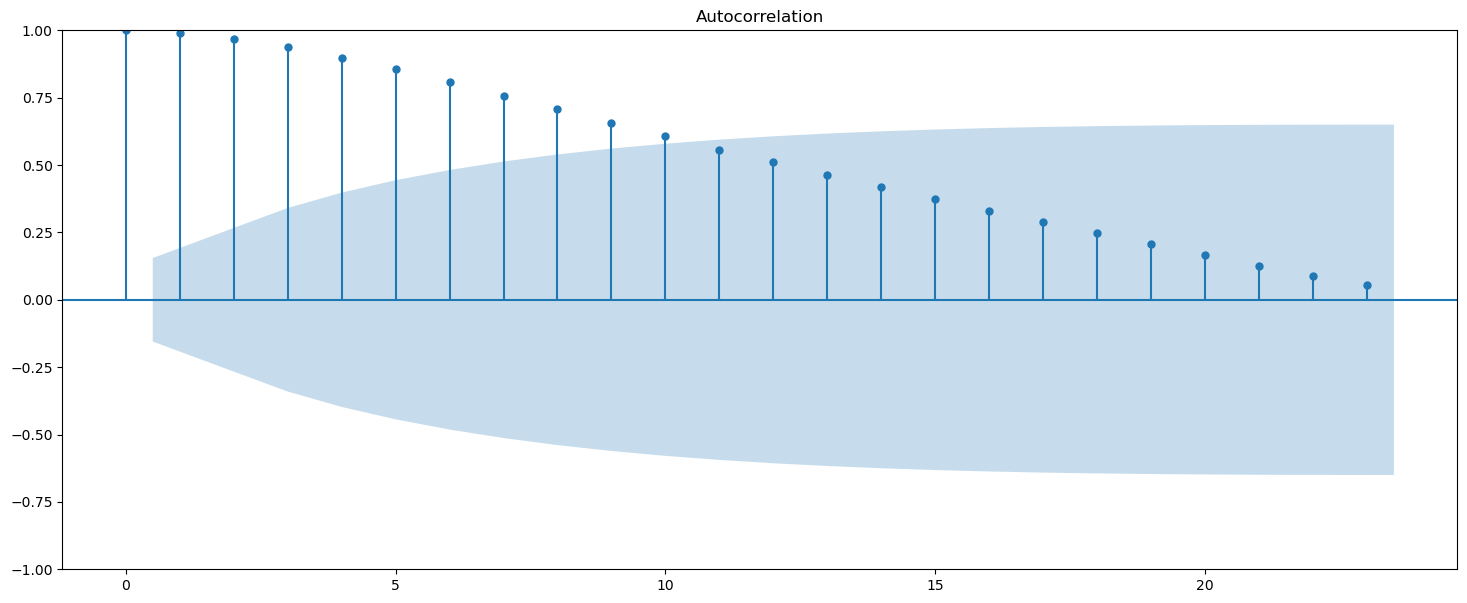

In [72]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots\n",
plot_acf(data_diff2)
plt.show()

In [73]:
#Conducting another round of differencing as data is still not stationary
data_diff3 = data_sub - data_sub.shift(3) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
   

In [74]:
data_diff3.dropna(inplace = True) # Here,missing values that came about as a result of the differencing are removed.
# If not removed,it will not be possible to run the Dickey-Fuller test

In [75]:
data_diff3.head()

,Value
datetime,
1980-10-01,-0.021875
1981-01-01,-0.023586
1981-04-01,-0.025027
1981-07-01,-0.026193
1981-10-01,-0.027092


In [76]:
data_diff3.columns

Index(['Value'], dtype='object')

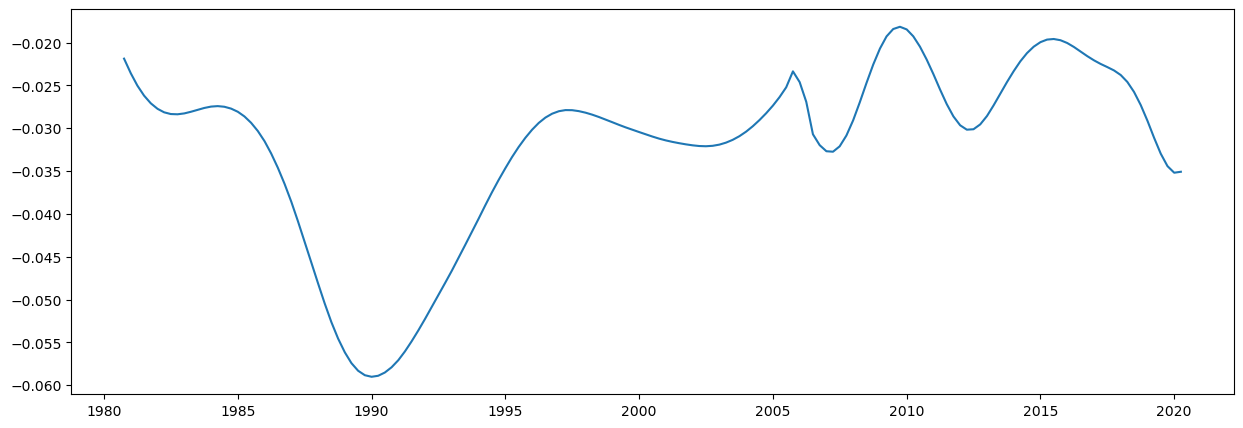

In [77]:
# Check out what the third differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff3)

In [78]:
#Conducting the dickey_fuller again after another differencing
dickey_fuller(data_diff3['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.219230
p-value                          0.199340
Number of Lags Used             10.000000
Number of Observations Used    148.000000
Critical Value (1%)             -3.475325
Critical Value (5%)             -2.881275
Critical Value (10%)            -2.577293
dtype: float64


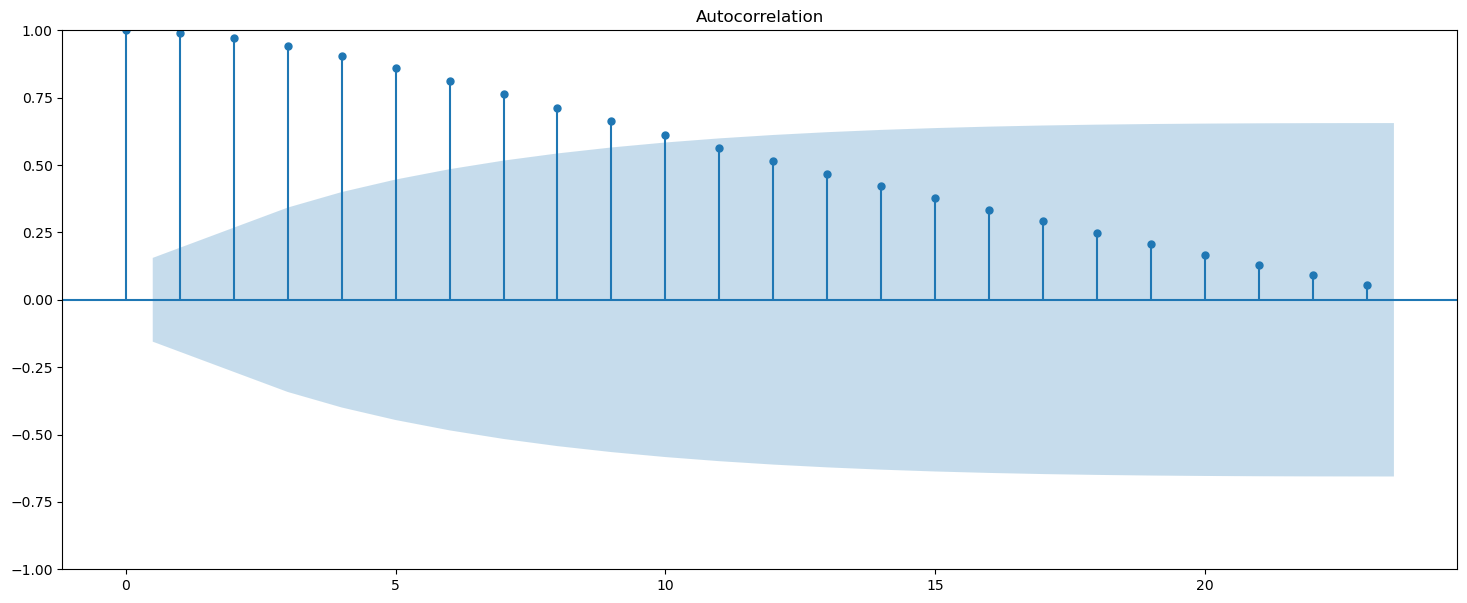

In [79]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots\n",
plot_acf(data_diff3)
plt.show()

In [ ]:
#comments
data is still not stationary as critical value is still less than test statistic after 3 differencing.I will be stopping here as because of the unspoken rule of thumb that I need at least ten significant lags (or ten vertical lines above the confidence interval) for a second round of differencing to be necessary.